In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

import mmh3

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
import xgboost


plt.style.use("dark_background")


In [2]:
df =pd.read_csv("./data/train_values.csv")
tr_labels = pd.read_csv("./data/train_labels.csv")
df = df.merge(tr_labels, how='left', on='id')

In [3]:
not_working =df[df['status_group'] != 'functional']
working = df[df['status_group'] == 'functional']

In [4]:
df.funder.value_counts(normalize=True)

Government Of Tanzania    0.162898
Danida                    0.055841
Hesawa                    0.039487
Rwssp                     0.024639
World Bank                0.024191
                            ...   
Mitema                    0.000018
Tlc/community             0.000018
Mwalimu Muhenza           0.000018
John Gileth               0.000018
Muwasa                    0.000018
Name: funder, Length: 1897, dtype: float64

In [5]:
df =df.drop([ 'funder', 'gps_height', 'installer', 'wpt_name'
            , 'num_private', 'population', 'public_meeting', 'recorded_by', 'permit',
            'scheme_management', 'scheme_name', 'quantity_group', 'extraction_type',
            'extraction_type_group', 'source', 'payment', 'waterpoint_type' ], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   basin                  59400 non-null  object 
 6   subvillage             59029 non-null  object 
 7   region                 59400 non-null  object 
 8   region_code            59400 non-null  int64  
 9   district_code          59400 non-null  int64  
 10  lga                    59400 non-null  object 
 11  ward                   59400 non-null  object 
 12  construction_year      59400 non-null  int64  
 13  extraction_type_class  59400 non-null  object 
 14  management             59400 non-null  object 
 15  ma

In [7]:
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['year_recorded'] = df['date_recorded'].apply(lambda x: x.strftime('%Y')).astype(int)
df['date_recorded'] = df['date_recorded'].apply(lambda x: x.strftime('%Y-%m'))


In [8]:
df_clone = df

In [9]:
tr_labels['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [10]:
df_cut = df[[ 'quantity', 'region', 'lga', 'extraction_type_class', 'waterpoint_type_group', 'payment_type', 'source_type', 'status_group', 'quality_group']]


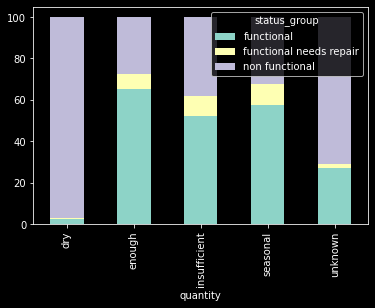

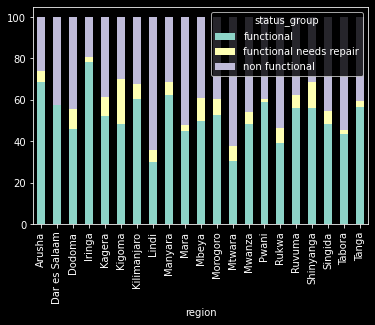

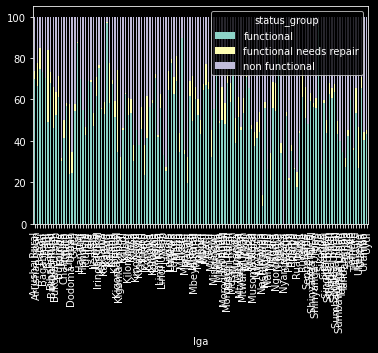

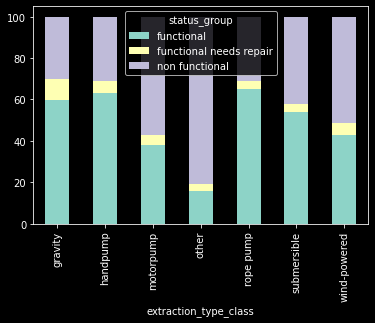

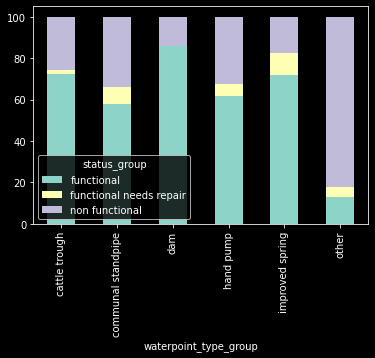

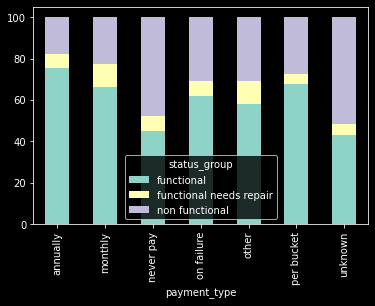

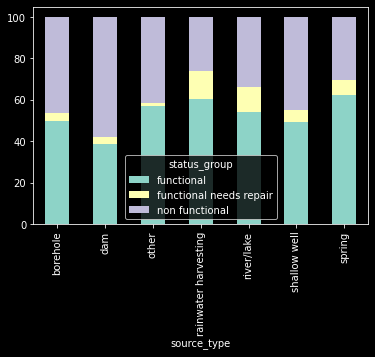

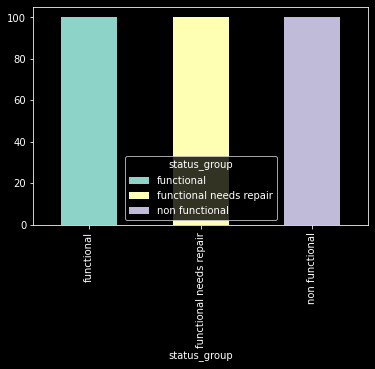

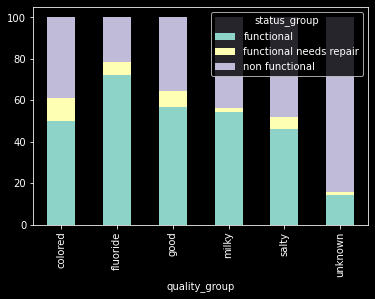

In [11]:
for column in df_cut:
    pd.crosstab(df_cut[column], df_cut['status_group']
                            ).apply(lambda x: x/x.sum()*100, axis=1
                            ).plot(kind="bar",stacked=True)

In [12]:
df.amount_tsh.value_counts(normalize=True)

0.0         0.700993
500.0       0.052222
50.0        0.041616
1000.0      0.025051
20.0        0.024630
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64

* I suspect(confidently) that 0s have been placed in place of the null values
* Simple logic: If you have 64% of the sources functional, you can't have 70% with 0 tsh.
* Ignore category
* Similar issues with the population and construction year.

In [13]:
df.describe()

,id,amount_tsh,longitude,latitude,region_code,district_code,construction_year,year_recorded
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,34.077427,-5.706033e+00,15.297003,5.629747,1300.652475,2011.921667
std,21453.128371,2997.574558,6.567432,2.946019e+00,17.587406,9.633649,951.620547,0.958758
min,0.000000,0.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,2002.000000
25%,18519.750000,0.000000,33.090347,-8.540621e+00,5.000000,2.000000,0.000000,2011.000000
50%,37061.500000,0.000000,34.908743,-5.021597e+00,12.000000,3.000000,1986.000000,2012.000000
75%,55656.500000,20.000000,37.178387,-3.326156e+00,17.000000,5.000000,2004.000000,2013.000000
max,74247.000000,350000.000000,40.345193,-2.000000e-08,99.000000,80.000000,2013.000000,2013.000000


In [14]:
def cat_comb(df, category, threshold=5):
    series = pd.value_counts(df[category])
    mask = (series / series.sum() * 100).lt(threshold)
    df[category] = np.where(df[category].isin(series[mask].index),'other', df[category])
    return df[category]


In [15]:
df.basin.value_counts(normalize=True)

Lake Victoria              0.172525
Pangani                    0.150505
Rufiji                     0.134276
Internal                   0.131061
Lake Tanganyika            0.108283
Wami / Ruvu                0.100791
Lake Nyasa                 0.085606
Ruvuma / Southern Coast    0.075640
Lake Rukwa                 0.041313
Name: basin, dtype: float64

def hashit(df, column):
    return df[column].apply(lambda x: mmh3.hash(x, seed=42, signed=True)&100)

In [16]:
#df['region'] = hashit(df, 'region')
df.lga.value_counts(normalize=True)

Njombe          0.042138
Arusha Rural    0.021077
Moshi Rural     0.021061
Bariadi         0.019815
Rungwe          0.018620
                  ...   
Moshi Urban     0.001330
Kigoma Urban    0.001195
Arusha Urban    0.001061
Lindi Urban     0.000354
Nyamagana       0.000017
Name: lga, Length: 125, dtype: float64

In [17]:
df['lga'] = df['lga'].apply(lambda x: x.split(" ")[0])
df.lga.value_counts(normalize=True)

Njombe       0.042138
Moshi        0.022391
Arusha       0.022138
Bariadi      0.019815
Singida      0.019731
               ...   
Ilemela      0.002391
Mafia        0.002222
Tanga        0.001667
Kinondoni    0.001566
Nyamagana    0.000017
Name: lga, Length: 114, dtype: float64

sns.histplot(df.status_group)



fig = plt.figure(figsize=(20,15))
ax = sns.scatterplot(data=working[working['construction_year'] != 0], x='longitude', y='latitude', alpha=0.2, hue='construction_year', marker='.')
'''
ax.set(  xlabel='Budget($100 Million)',
         ylabel='Return on Investment(%)', 
         title='Returns by Budget',
         xticks=np.arange(0, 340000000, 50000000), 
         yticks=np.arange(0, 51, 10),  )
'''

plt.xlim([29,41])
plt.ylim([-12,0])
plt.show()

In [18]:
df = df.drop(['id', 'amount_tsh', 'date_recorded', 'year_recorded','status_group', 'construction_year', 'management'], axis=1)

In [19]:
df_cont = df[['latitude', 'longitude']]
df_cat = df.drop(['latitude', 'longitude'], axis=1)

In [20]:
df_catstr = df_cat.drop(['region_code', 'district_code'], axis=1)

In [21]:
df_cat

,basin,subvillage,region,region_code,district_code,lga,ward,extraction_type_class,management_group,payment_type,water_quality,quality_group,quantity,source_type,source_class,waterpoint_type_group
0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,gravity,user-group,annually,soft,good,enough,spring,groundwater,communal standpipe
1,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,gravity,user-group,never pay,soft,good,insufficient,rainwater harvesting,surface,communal standpipe
2,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,gravity,user-group,per bucket,soft,good,enough,dam,surface,communal standpipe
3,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,submersible,user-group,never pay,soft,good,dry,borehole,groundwater,communal standpipe
4,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,gravity,other,never pay,soft,good,seasonal,rainwater harvesting,surface,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,gravity,user-group,per bucket,soft,good,enough,spring,groundwater,communal standpipe
59396,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,gravity,user-group,annually,soft,good,enough,river/lake,surface,communal standpipe
59397,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,handpump,user-group,monthly,fluoride,fluoride,enough,borehole,groundwater,hand pump
59398,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,handpump,user-group,never pay,soft,good,insufficient,shallow well,groundwater,hand pump


In [22]:
df_cont = pd.DataFrame(df_cont)

In [23]:
scaler = MinMaxScaler()

df_cont = scaler.fit_transform(df_cont)
df_cont = pd.DataFrame(df_cont)

In [24]:
for column in df_cat:
    print(column)
    print (len(df_cat[column].value_counts()))

basin
9
subvillage
19287
region
21
region_code
27
district_code
20
lga
114
ward
2092
extraction_type_class
7
management_group
5
payment_type
7
water_quality
8
quality_group
6
quantity
5
source_type
7
source_class
3
waterpoint_type_group
6


In [25]:
df_cat = df_cat.drop(['subvillage', 'ward', 'basin', 'source_class', 'water_quality'], axis=1)

In [26]:
df_cat = pd.get_dummies(df_cat)


df_cat[['region', 'region_code', 'district_code']] =df_cat[['region', 'region_code', 'district_code']].astype('string')

for column in df_cat:
   df_cat[column] = hashit(df_cat, column)

In [27]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Columns: 180 entries, region_code to waterpoint_type_group_other
dtypes: int64(2), uint8(178)
memory usage: 11.4 MB


In [28]:
df = pd.concat([df_cont, df_cat], axis=1)

In [29]:
le = LabelEncoder()

tr_labels = le.fit_transform(tr_labels.status_group)


In [30]:
X = df
y = tr_labels

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)

In [32]:
X_test.shape

(14850, 182)

In [33]:
tree = DecisionTreeClassifier(criterion='gini', 
#                            max_features='log2',
#                            min_samples_leaf=2, 
#                            max_depth=20, 
                            class_weight='balanced')
clf_dt = tree.fit(X_train, y_train)

# Test set predictions
pred = tree.predict(X_test)
# Confusion matrix and classification report

pred_tr = tree.predict(X_train)

print(confusion_matrix(y_test, pred))

print(classification_report(y_test, pred))

print("Training Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_train, pred_tr) * 100))
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))


[[6406  504 1145]
 [ 462  421  198]
 [1189  201 4324]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      8055
           1       0.37      0.39      0.38      1081
           2       0.76      0.76      0.76      5714

    accuracy                           0.75     14850
   macro avg       0.64      0.65      0.65     14850
weighted avg       0.75      0.75      0.75     14850

Training Accuracy for Decision Tree Classifier: 99.22%
Testing Accuracy for Decision Tree Classifier: 75.09%


def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree)

In [34]:
tree.feature_importances_
df.columns
feature_imp = pd.DataFrame({'feature': df.columns, 'importance': tree.feature_importances_*100})
feature_imp.sort_values(by=['importance'], ascending=False).head(20)

,feature,importance
1,1,30.650810
0,0,26.801175
164,quantity_dry,8.987951
142,extraction_type_class_other,3.390434
3,district_code,1.765696
139,extraction_type_class_gravity,1.711389
7,region_Iringa,1.349997
175,source_type_spring,1.025284
179,waterpoint_type_group_hand pump,0.981884
165,quantity_enough,0.932522


,feature,importance
3,lga,12.163934
10,source_type,11.366511
6,payment_type,10.771261
2,district_code,10.177237
4,extraction_type_class,10.063785
9,quantity,9.341607
1,region_code,9.285020
0,region,8.750916
5,management_group,4.486133
12,waterpoint_type_group,3.955747


* The above is for the hash trick

In [35]:
clf = RandomForestClassifier( n_estimators=200, 
                            max_samples=0.25,
 #                           min_samples_leaf=1, 
                            max_depth=20,  
                            class_weight='balanced'
                            ).fit(X_train, y_train)

pred = clf.predict(X_test)

# Test set predictions
pred_tr = clf.predict(X_train)
# Confusion matrix and classification report

print("Training Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_train, pred_tr)* 100))

print("Testing Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_test, pred)* 100))

print(confusion_matrix(y_test, pred))

print(classification_report(y_test, pred))

Training Accuracy for Random Forest Classifier: 83.5%
Testing Accuracy for Random Forest Classifier: 78.08%
[[7020  474  561]
 [ 482  467  132]
 [1397  209 4108]]
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      8055
           1       0.41      0.43      0.42      1081
           2       0.86      0.72      0.78      5714

    accuracy                           0.78     14850
   macro avg       0.68      0.67      0.68     14850
weighted avg       0.79      0.78      0.78     14850



In [36]:
feature_imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_*100})
feature_imp.sort_values(by=['importance'], ascending=False).head(20)

,feature,importance
1,1,16.639402
0,0,15.803081
164,quantity_dry,7.598171
3,district_code,3.196207
165,quantity_enough,2.994242
142,extraction_type_class_other,2.865857
2,region_code,2.775976
181,waterpoint_type_group_other,2.237174
139,extraction_type_class_gravity,2.003688
166,quantity_insufficient,1.991682


Based on these, let's try to see what's important.
* Quantity is very important, especially dry and enough.
* Only use 1 geographic column. Region, especially Kigoma and Iringa 
* Extraction Type: Other and Gravity
* Waterpoint Type: Other and communal standpipe
* Payment Type: Never pay, per bucket, monthly, unknown
* Source Type: Borehole, shallow well

In [37]:
#Pipeline

'''mapper = DataFrameMapper(
    [(d, LabelEncoder()) for d in dummies])'''

lm = make_pipeline(OneHotEncoder(),
                   (RandomForestClassifier(class_weight='balanced')))



In [38]:
df_cut = df_cut.drop('status_group', 1)
df_cut = pd.get_dummies(df_cut)
df_cut = pd.concat([df_cont, df_cat], axis=1)

In [39]:
X = df_cut
y = tr_labels

(59400, 56)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)

In [41]:
rfc = RandomForestClassifier(class_weight='balanced').fit(X_train, y_train)

pred = rfc.predict(X_test)
pred_tr = rfc.predict(X_train)

print("Training Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_train, pred_tr)* 100))

print("Testing Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_test, pred)* 100))

print(confusion_matrix(y_test, pred))

print(classification_report(y_test, pred))

Training Accuracy for Random Forest Classifier: 99.23%
Testing Accuracy for Random Forest Classifier: 78.6%
[[6849  336  870]
 [ 500  419  162]
 [1187  123 4404]]
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      8055
           1       0.48      0.39      0.43      1081
           2       0.81      0.77      0.79      5714

    accuracy                           0.79     14850
   macro avg       0.70      0.67      0.68     14850
weighted avg       0.78      0.79      0.78     14850



In [42]:
rfc.feature_importances_

array([2.41412310e-01, 2.50040024e-01, 1.94828165e-02, 2.74494034e-02,
       2.34920257e-03, 7.25292942e-04, 1.75243158e-03, 6.50040768e-03,
       1.59198591e-03, 5.48680431e-03, 2.28196947e-03, 1.37480382e-03,
       1.19785385e-03, 1.90003130e-03, 2.66386199e-03, 2.30473269e-03,
       1.25368853e-03, 2.54106031e-03, 2.37478894e-03, 1.29514767e-03,
       1.58943109e-03, 4.65518570e-03, 1.89980877e-03, 1.42945189e-03,
       2.13021120e-03, 9.89346155e-04, 7.36987430e-04, 8.28587171e-04,
       3.74026967e-04, 7.66577992e-03, 6.85376325e-04, 1.35648362e-03,
       6.72977801e-04, 4.98232086e-04, 4.96068145e-04, 4.00046193e-04,
       2.08922246e-03, 7.93669940e-04, 7.39967143e-04, 9.36870974e-04,
       8.03016106e-04, 2.18028139e-04, 6.20412083e-04, 4.32629253e-04,
       4.63617249e-04, 3.56599717e-04, 7.19376840e-04, 7.06433229e-04,
       9.34425923e-04, 8.01229594e-04, 8.01789808e-04, 1.11019402e-03,
       4.16082627e-04, 8.33804791e-04, 4.36077734e-03, 2.33680342e-04,
      

In [43]:
from sklearn.model_selection import cross_val_score

cross_val_score(rfc, X_test, y_test, cv=5, estimator='accuracy').mean()

0.7527272727272727

In [44]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf, X_test, y_test, cv=5, estimator='accuracy').mean()

0.762020202020202

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Columns: 182 entries, 0 to waterpoint_type_group_other
dtypes: float64(2), int64(2), uint8(178)
memory usage: 11.9 MB


fig = plt.figure(figsize=(20,15))
ax = sns.scatterplot(data=df, x='longitude', y='latitude', alpha=0.2, hue='region_code', marker='.')
'''
ax.set(  xlabel='Budget($100 Million)',
         ylabel='Return on Investment(%)', 
         title='Returns by Budget',
         xticks=np.arange(0, 340000000, 50000000), 
         yticks=np.arange(0, 51, 10),  )
'''

plt.xlim([29,41])
plt.ylim([-12,0])
plt.show()

missing_year = df[df['construction_year'] == 0]
has_year = df[df['construction_year']  != 0]

In [46]:
df.region_code.unique()

array([11, 20, 21, 90, 18,  4, 17, 14, 60, 10,  3, 15, 19, 16, 80,  1,  6,
        2, 12, 13,  5,  7, 99, 24,  9,  8, 40], dtype=int64)

In [47]:
df.region_code.value_counts(normalize=True)

11    0.089226
17    0.084360
12    0.078098
3     0.073721
5     0.068013
18    0.055960
19    0.051296
2     0.050909
16    0.047407
10    0.044444
4     0.042306
1     0.037054
13    0.035236
14    0.033316
20    0.033148
15    0.030438
6     0.027088
21    0.026650
80    0.020842
60    0.017256
90    0.015438
7     0.013552
99    0.007121
9     0.006566
24    0.005488
8     0.005051
40    0.000017
Name: region_code, dtype: float64

# Strategy

* Decision Tree, Bagged, RandomForest
* Model 0: Nothing encoded or changed.
* Model 1: One Hot
    * decrease cats
* Model 2: Hash
    * decrease cats
* Fix for skew